In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
print(os.listdir("../input"))

['train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv']


In [2]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans

In [3]:
%%time
train = load_df('../input/train_v2.csv')
test = load_df('../input/test_v2.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

train date: 20160801 to 20180430
test date: 20180501 to 20181015
CPU times: user 13min 4s, sys: 50.5 s, total: 13min 55s
Wall time: 13min 55s


In [4]:
# Thanks and credited to https://www.kaggle.com/gemartin
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 398042601.00 MB
Memory usage after optimization is: 369000872.00 MB
Decreased by 7.3%
Memory usage of dataframe is 93570317.00 MB
Memory usage after optimization is: 86743304.00 MB
Decreased by 7.3%


In [5]:
# only train feature
for c in train.columns.values:
    if c not in test.columns.values: print(c)

In [6]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'].astype(float))
print(train['totals.transactionRevenue'].describe())

count    1.708337e+06
mean     1.925875e-01
std      1.844057e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.386437e+01
Name: totals.transactionRevenue, dtype: float64


In [7]:
test['totals.transactionRevenue'] = np.nan

# 

In [8]:
all_data = train.append(test, sort=False).reset_index(drop=True)

In [9]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 30 columns):
channelGrouping               object
date                          int32
fullVisitorId                 object
visitId                       int32
visitNumber                   int16
visitStartTime                int32
device.browser                object
device.deviceCategory         object
device.isMobile               float16
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     float64
trafficSource.adContent       object
trafficSource.campaign        object
t

In [10]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                  239
totals.newVisits               400907
totals.bounces                 836759
trafficSource.keyword         1052780
trafficSource.referralPath    1142073
trafficSource.isTrueDirect    1173819
trafficSource.adContent       1643600
dtype: int64


In [11]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    all_data[col].fillna('unknown', inplace=True)

# fillna numeric feature
all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int)

# fillna boolean feature
all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [12]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
#for c in constant_column:
#    print(c + ':', train[c].unique())

print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: []


In [13]:
# pickup any visitor
all_data[all_data['fullVisitorId'] == '7813149961404844386'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews']].head(20)

,date,visitId,visitNumber,totals.hits,totals.pageviews
314476,20161117,1479408977,1,37,33
31816,20161118,1479496350,2,2,2
32524,20161118,1479507825,3,14,12
338140,20161122,1479831970,4,3,3
338305,20161122,1479842287,5,4,4
495433,20161202,1480691778,13,1,1
1203329,20161206,1481036817,14,12,10
1204477,20161206,1481040342,15,1,1
1203514,20161206,1481061263,16,28,19
1203516,20161206,1481065071,17,28,26


In [14]:
train_rev = train[train['totals.transactionRevenue'] > 0].copy()
print(len(train_rev))
train_rev.head()

18514


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
433,Organic Search,20171016,9549826748224805897,1508200705,4,1508200705,Chrome,desktop,0.0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,NaN,9,NaN,9,16.536148,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
550,Referral,20171016,3700714855829972615,1508192636,11,1508192636,Chrome,desktop,0.0,Windows,Irvine,Americas,United States,Los Angeles CA,(not set),California,Northern America,NaN,15,NaN,12,15.894952,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
555,Organic Search,20171016,1572225825161580042,1508162218,6,1508162218,Safari,mobile,1.0,iOS,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,purechat.com,California,Northern America,NaN,15,NaN,15,17.863811,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
597,Referral,20171016,7187192533100162289,1508189401,17,1508189401,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,18,NaN,16,16.718579,NaN,(not set),True,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
619,Referral,20171016,7889233516776348524,1508190484,1,1508190484,Chrome,desktop,0.0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,NaN,21,1,20,16.325923,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"


In [15]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.sort_values('Revenue').plot.barh(colormap='jet')

## customDimensions

unique customDimensions count: 6


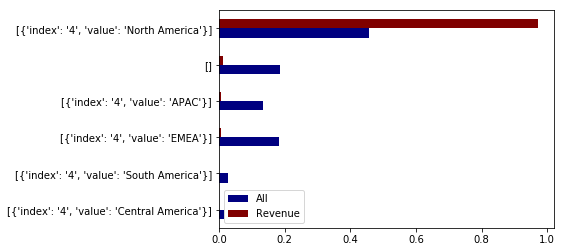

In [16]:
print('unique customDimensions count:', train['customDimensions'].nunique())
plotCategoryRateBar(all_data, train_rev, 'customDimensions')

## date

In [17]:
format_str = '%Y%m%d'
all_data['formated_date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_year'] = all_data['formated_date'].apply(lambda x:x.year)
all_data['_month'] = all_data['formated_date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['formated_date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['formated_date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['formated_date'].apply(lambda x:x.weekday())

all_data.drop(['date','formated_date'], axis=1, inplace=True)

## channelGrouping
* The channel via which the user came to the Store.

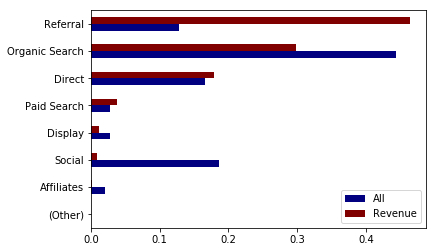

In [18]:
plotCategoryRateBar(all_data, train_rev, 'channelGrouping')

## fullVisitorId
* A unique identifier for each user of the Google Merchandise Store.

## visitId
* An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.   
For a completely unique ID, you should use a combination of fullVisitorId and visitId.

## newVisits


In [19]:
print('train all:', len(train))
print('train unique fullVisitorId:', train['fullVisitorId'].nunique())
print('train unique visitId:', train['visitId'].nunique())
print('-' * 30)
print('test all:', len(test))
print('test unique fullVisitorId:', test['fullVisitorId'].nunique())
print('test unique visitId:', test['visitId'].nunique())

#print('common fullVisitorId:', len(pd.merge(train, test, how='inner', on='fullVisitorId'))) # 183434

train all: 1708337
train unique fullVisitorId: 1323730
train unique visitId: 1665802
------------------------------
test all: 401589
test unique fullVisitorId: 296530
test unique visitId: 393181


In [20]:
print(all_data['visitNumber'].value_counts()[:5])
print('-' * 30)
print(all_data['totals.newVisits'].value_counts())
print('-' * 30)
print(all_data['totals.bounces'].value_counts())

1    1593495
2     235089
3      92462
4      49195
5      30281
Name: visitNumber, dtype: int64
------------------------------
1    1593495
0     516431
Name: totals.newVisits, dtype: int64
------------------------------
0    1055670
1    1054256
Name: totals.bounces, dtype: int64


In [21]:
#maxVisitNumber = max(all_data['visitNumber'])
#fvid = all_data[all_data['visitNumber'] == maxVisitNumber]['fullVisitorId']
#all_data[all_data['fullVisitorId'] == fvid.values[0]].sort_values(by='visitNumber')

In [22]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

## device

unique browser count: 129


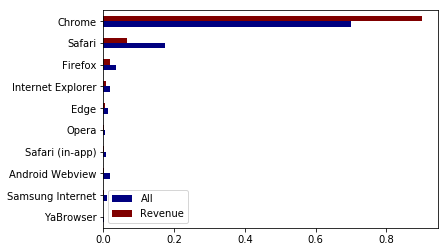

In [23]:
print('unique browser count:', train['device.browser'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.browser', 10)

In [24]:
pd.crosstab(all_data['device.deviceCategory'], all_data['device.isMobile'], margins=False)

all_data['isMobile'] = True
all_data.loc[all_data['device.deviceCategory'] == 'desktop', 'isMobile'] = False

unique operatingSystem count: 24


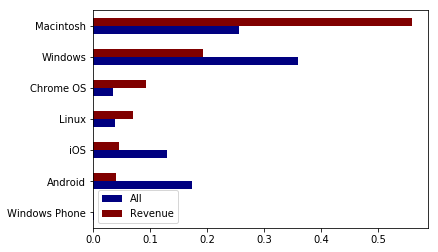

In [25]:
print('unique operatingSystem count:', train['device.operatingSystem'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.operatingSystem', 10)

## geoNetwork

unique geoNetwork.city count: 956


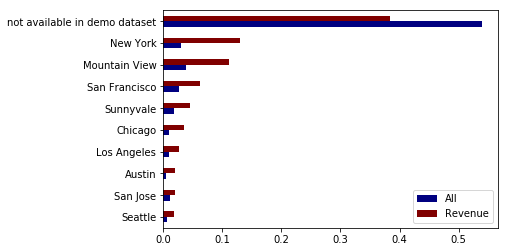

In [26]:
print('unique geoNetwork.city count:', train['geoNetwork.city'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.city', 10)

unique geoNetwork.region count: 483


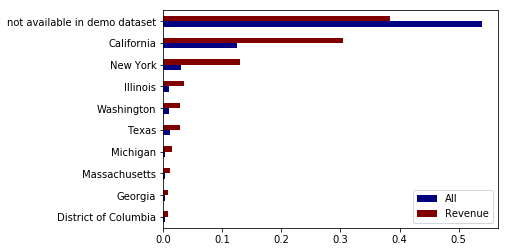

In [27]:
print('unique geoNetwork.region count:', train['geoNetwork.region'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.region', 10)

unique geoNetwork.subContinent count: 23


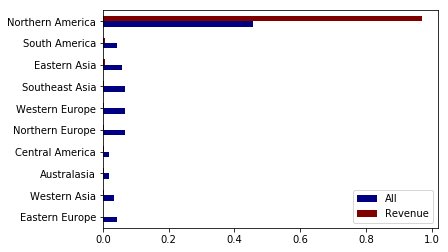

In [28]:
print('unique geoNetwork.subContinent count:', train['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.subContinent', 10)

unique geoNetwork.continent count: 6


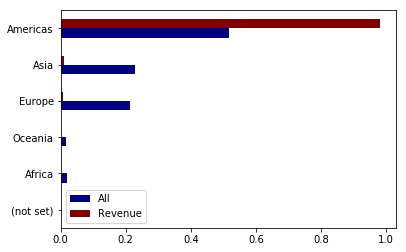

In [29]:
print('unique geoNetwork.continent count:', train['geoNetwork.continent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.continent')

unique geoNetwork.metro count: 123


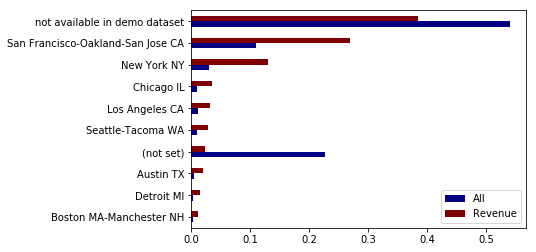

In [30]:
print('unique geoNetwork.metro count:', train['geoNetwork.metro'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.metro', 10)

unique geoNetwork.networkDomain count: 41982


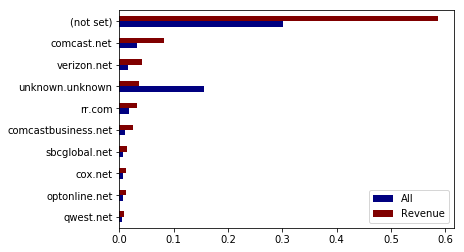

In [31]:
print('unique geoNetwork.networkDomain count:', train['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.networkDomain', 10)

## totals

In [32]:
print(all_data['totals.hits'].value_counts()[:10])

all_data['totals.hits'] = all_data['totals.hits'].astype(int)

1     1045156
2      283836
3      168381
4      102102
5       80768
6       60538
7       49807
8       38821
9       32625
10      26928
Name: totals.hits, dtype: int64


In [33]:
print(all_data['totals.pageviews'].value_counts()[:10])

all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)

1     1060594
2      302017
3      179197
4      110206
5       83130
6       62055
7       49242
8       38807
9       31508
10      25414
Name: totals.pageviews, dtype: int64


In [34]:
#print(all_data['totals.visits'].value_counts())

## trafficSource

unique trafficSource.adContent count: 76


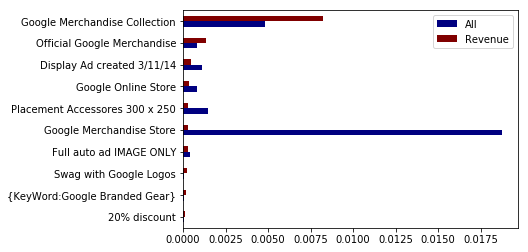

In [35]:
print('unique trafficSource.adContent count:', train['trafficSource.adContent'].nunique())

plotCategoryRateBar(all_data, train_rev, 'trafficSource.adContent', 10)

all_data['_adContentGMC'] = (all_data['trafficSource.adContent'] == 'Google Merchandise Collection').astype(np.uint8)

unique trafficSource.campaign count: 33


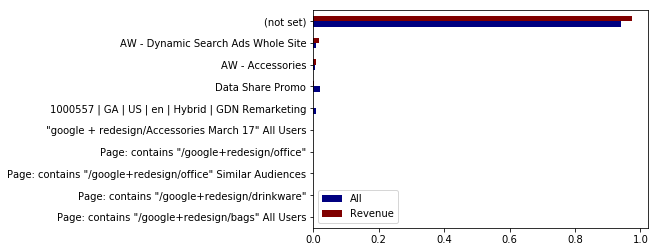

In [36]:
print('unique trafficSource.campaign count:', train['trafficSource.campaign'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.campaign', 10)

all_data['_withCampaign'] = (all_data['trafficSource.campaign'] != '(not set)').astype(np.uint8)

False    1426999
True      682927
Name: trafficSource.isTrueDirect, dtype: int64


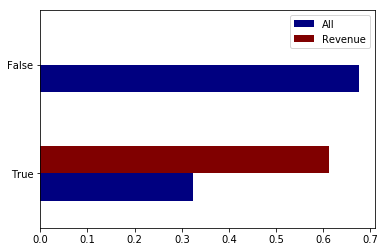

In [37]:
print(all_data['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.isTrueDirect')

unique trafficSource.keyword count: 4546


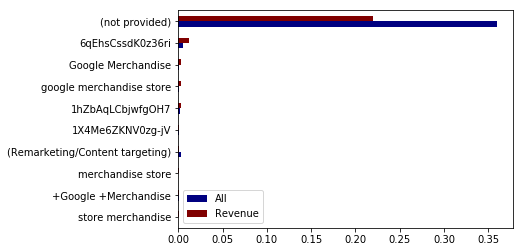

In [38]:
print('unique trafficSource.keyword count:', train['trafficSource.keyword'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.keyword', 10)

unique trafficSource.medium count: 7


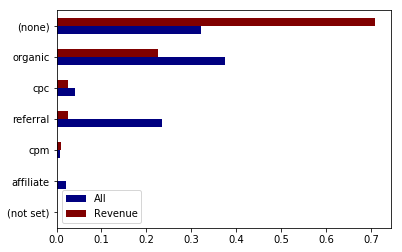

In [39]:
print('unique trafficSource.medium count:', train['trafficSource.medium'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.medium')

unique trafficSource.referralPath count: 3196


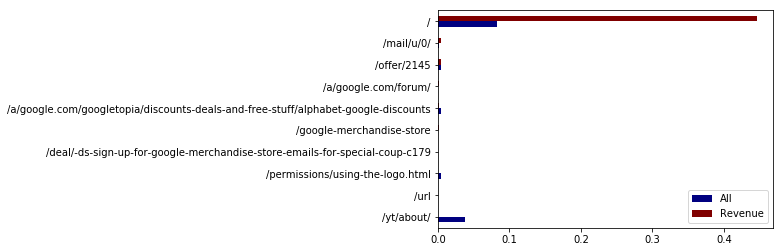

In [40]:
print('unique trafficSource.referralPath count:', train['trafficSource.referralPath'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.referralPath', 10)

all_data['_referralRoot'] = (all_data['trafficSource.referralPath'] == '/').astype(np.uint8)

unique trafficSource.source count: 345


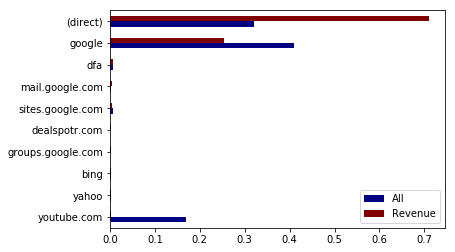

In [41]:
print('unique trafficSource.source count:', train['trafficSource.source'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.source', 10)

all_data['_sourceGpmall'] = (all_data['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)

## Aggregate

In [42]:
_='''
'''
all_data['_meanHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('mean')
all_data['_meanHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('mean')
all_data['_meanHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('mean')
all_data['_sumHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('sum')
all_data['_sumHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('sum')
all_data['_sumHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = all_data.groupby('fullVisitorId')[feature].mean()
    all_data['_usermean_' + feature] = all_data.fullVisitorId.map(info)
    
for feature in ['visitNumber']:
    info = all_data.groupby('fullVisitorId')[feature].max()
    all_data['_usermax_' + feature] = all_data.fullVisitorId.map(info)

del info

In [43]:
all_data['_source.country'] = all_data['trafficSource.source'] + '_' + all_data['geoNetwork.country']
all_data['_campaign.medium'] = all_data['trafficSource.campaign'] + '_' + all_data['trafficSource.medium']
all_data['_browser.category'] = all_data['device.browser'] + '_' + all_data['device.deviceCategory']
all_data['_browser.os'] = all_data['device.browser'] + '_' + all_data['device.operatingSystem']

## Select feature

In [44]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.transactionRevenue    401589
dtype: int64


In [45]:
all_data.drop(['visitId','visitStartTime'],axis=1,inplace=True)

for i, t in all_data.loc[:, all_data.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        all_data[i].fillna('unknown', inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')

# Prediction

In [46]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 51 columns):
channelGrouping               int64
fullVisitorId                 object
visitNumber                   int16
device.browser                int64
device.deviceCategory         int64
device.isMobile               float16
device.operatingSystem        int64
geoNetwork.city               int64
geoNetwork.continent          int64
geoNetwork.country            int64
geoNetwork.metro              int64
geoNetwork.networkDomain      int64
geoNetwork.region             int64
geoNetwork.subContinent       int64
totals.bounces                int64
totals.hits                   int64
totals.newVisits              int64
totals.pageviews              int64
totals.transactionRevenue     float64
trafficSource.adContent       int64
trafficSource.campaign        int64
trafficSource.isTrueDirect    bool
trafficSource.keyword         int64
trafficSource.medium          int64
trafficSource.refer

In [47]:
train = all_data[all_data['totals.transactionRevenue'].notnull()]
test = all_data[all_data['totals.transactionRevenue'].isnull()].drop(['totals.transactionRevenue'], axis=1)

In [48]:
test.shape

(401589, 50)

In [49]:
train_id = train['fullVisitorId']
test_id = test['fullVisitorId']

Y_train_reg = train.pop('totals.transactionRevenue')
#Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = train.drop(['fullVisitorId'], axis=1)
X_test  = test.drop(['fullVisitorId'], axis=1)

print(X_train.shape, X_test.shape)

(1708337, 49) (401589, 49)


In [50]:
del all_data, train, test, train_rev
gc.collect()

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

          name       size
0      X_train  580834604
1     train_id  143293686
2       X_test  136540284
3      test_id   33685432
4  Y_train_reg   27333416
5     null_cnt       9086
6          _14       8622
7          _i4       1887
8          _13       1808
9           __       1808


In [51]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [52]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

folds = GroupKFold(n_splits=5)

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train_reg, groups=train_id)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train_reg.iloc[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration_) / folds.n_splits

pred = sub_preds

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.53864
[1000]	valid_0's rmse: 1.52585
[1500]	valid_0's rmse: 1.52045
[2000]	valid_0's rmse: 1.51729
[2500]	valid_0's rmse: 1.5156
[3000]	valid_0's rmse: 1.51447
Did not meet early stopping. Best iteration is:
[3000]	valid_0's rmse: 1.51447
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.5451
[1000]	valid_0's rmse: 1.53292
[1500]	valid_0's rmse: 1.52698
[2000]	valid_0's rmse: 1.52391
[2500]	valid_0's rmse: 1.52233
[3000]	valid_0's rmse: 1.52109
Did not meet early stopping. Best iteration is:
[2962]	valid_0's rmse: 1.52107
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.5255
[1000]	valid_0's rmse: 1.513
[1500]	valid_0's rmse: 1.50603
[2000]	valid_0's rmse: 1.50303
[2500]	valid_0's rmse: 1.50109
[3000]	valid_0's rmse: 1.49934
Did not meet early stopping. Best iteration is:
[2968]	valid_0's rmse: 1.49932
Training until validation s

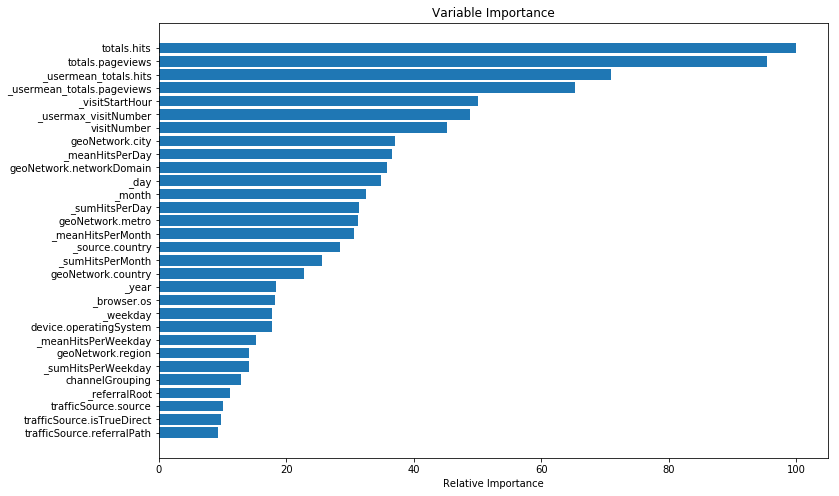

In [53]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [54]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("submission.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.009337
1,0000039738481224681,0.000000
2,0000073585230191399,0.000000
3,0000087588448856385,0.000000
4,0000149787903119437,0.000000
5,0000196310838896290,2.085678
6,00001995526696366,0.000000
7,0000255704530917106,0.133832
8,0000268499301061358,0.000000
9,0000276747989270229,0.014831


In [55]:
submission_sum['PredictedLogRevenue'].describe()

count    296530.000000
mean          0.240123
std           1.131508
min           0.000000
25%           0.000000
50%           0.000000
75%           0.004056
max          17.471728
Name: PredictedLogRevenue, dtype: float64